In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score

import imblearn

from imblearn.over_sampling import SMOTE

In [2]:
df_label= pd.read_csv('train_labels.csv',index_col='building_id')

df_features = pd.read_csv('train_values.csv',index_col='building_id')

In [3]:
df = df_features.join(df_label)

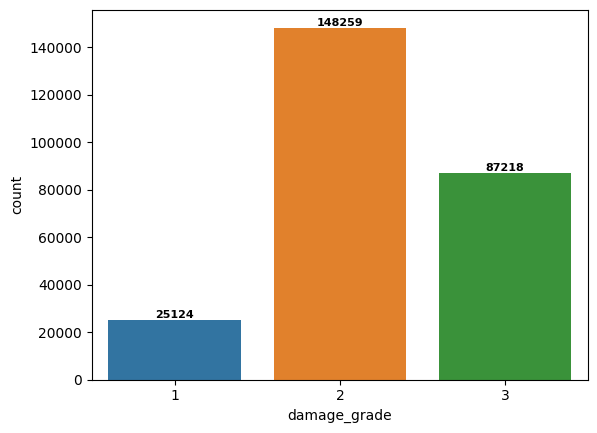

In [99]:
#Imbalanced class problem

fig, ax= plt.subplots()

sns.countplot(data=df,x='damage_grade')

for i in ax.containers:
    ax.bar_label(i,fontsize=8,weight='bold')

plt.show()

In [5]:
len(df.columns)

39

In [6]:
#No null values
df.isnull().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

In [93]:
object_cols=df.select_dtypes('object').columns

object_cols

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')

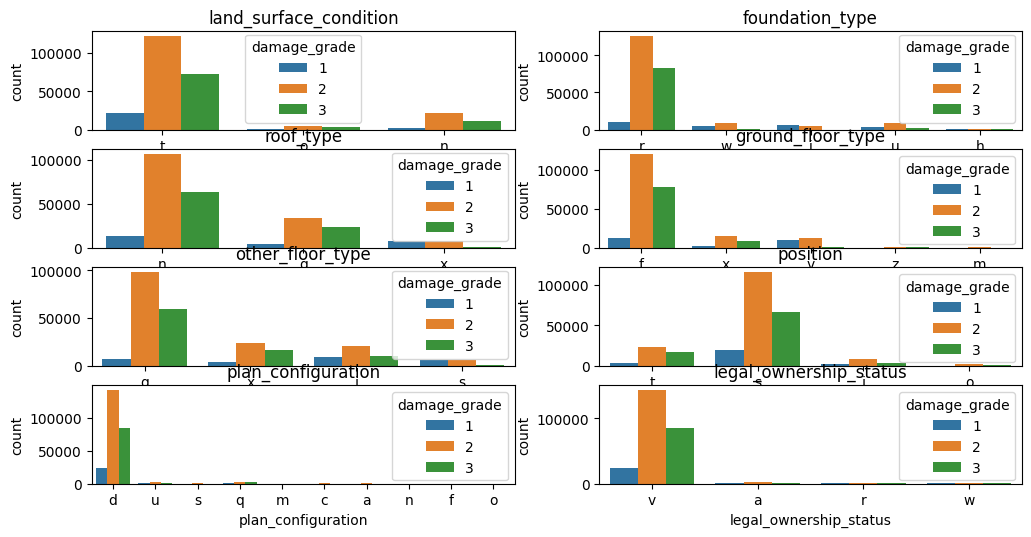

In [113]:
fig = plt.figure(figsize=(12,12))
for i, col in enumerate(object_cols):
    plt.subplot(len(object_cols), 2, i+1)
    
    ax=sns.countplot(x=col,hue='damage_grade', data=df)
    ax.set_title(col)

In [87]:
oversample = SMOTE()

X,y =df_features , df_label

X, y = oversample.fit_resample(X, y)

ValueError: could not convert string to float: 't'

In [7]:
df['damage_grade']

building_id
802906    3
28830     2
94947     3
590882    2
201944    3
         ..
688636    2
669485    3
602512    3
151409    2
747594    3
Name: damage_grade, Length: 260601, dtype: int64

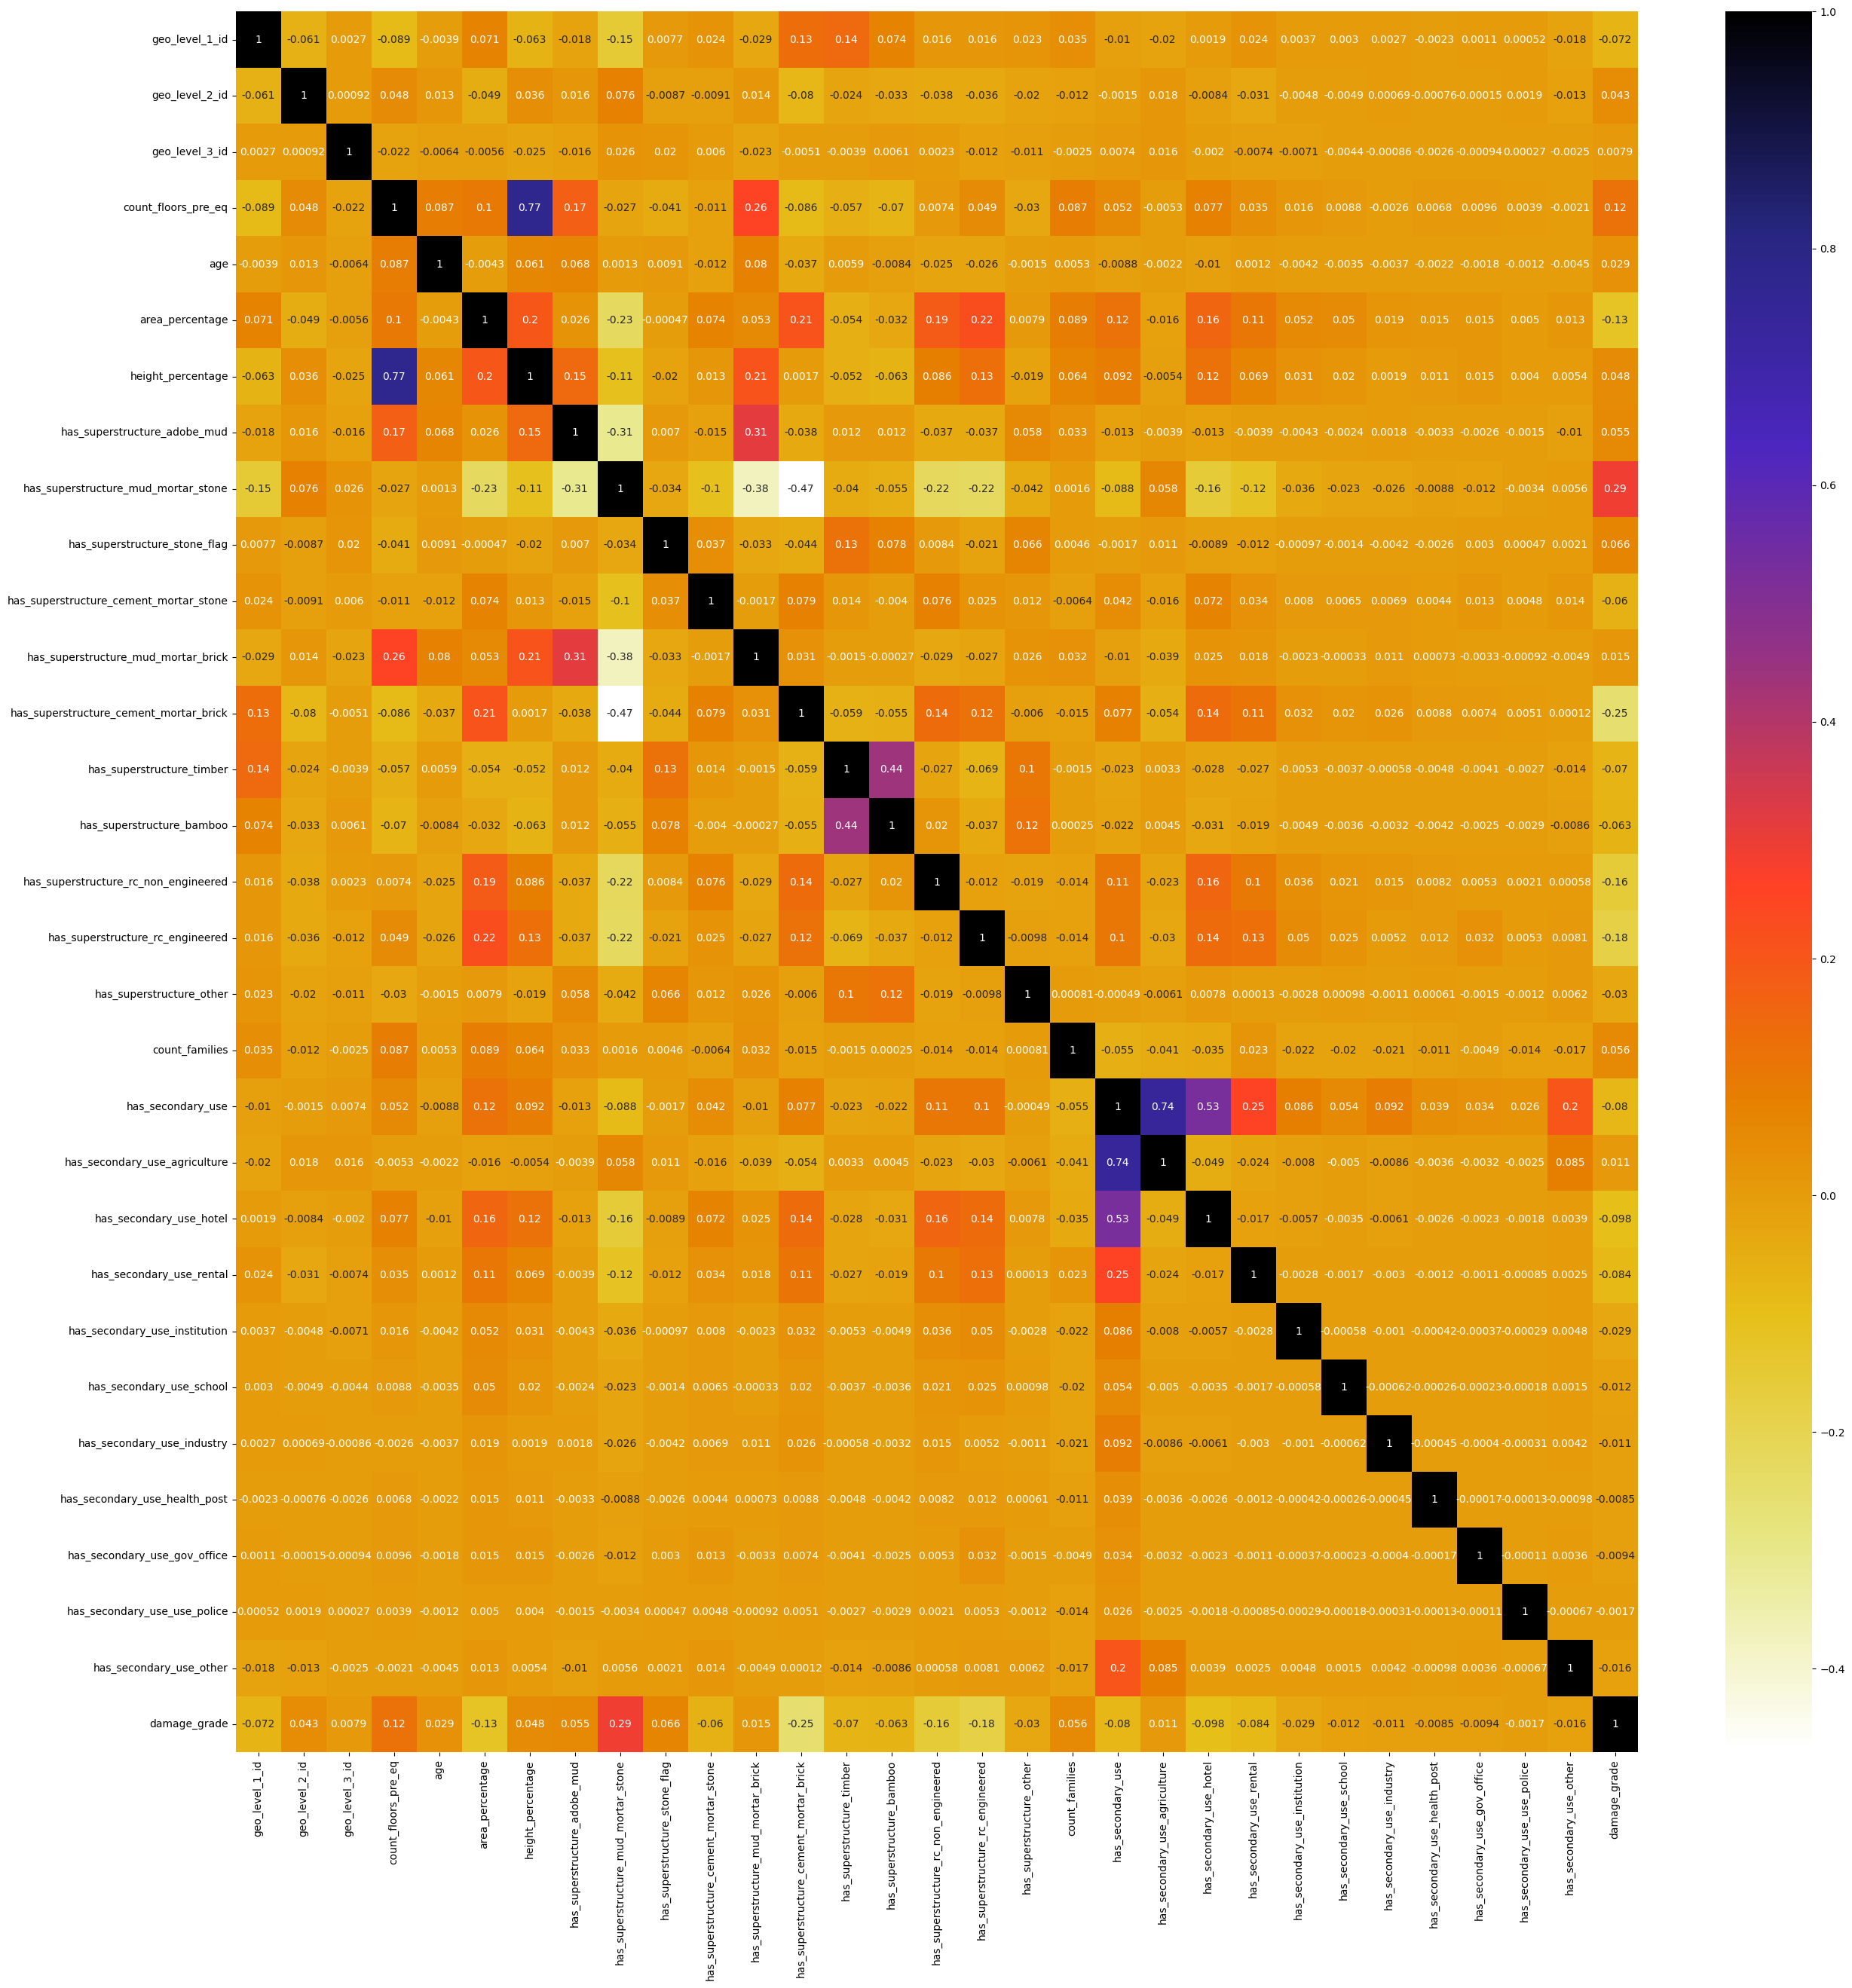

In [8]:
#Looking at the Multicolinearity and the relationship between Features and target
fig, ax= plt.subplots(figsize=(30,30))
sns.heatmap(df.corr(),annot=True,cmap='CMRmap_r')

plt.show()


In [9]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [10]:
corr_features=correlation(df,0.7)
len(set(corr_features))

2

In [11]:
corr_features

{'has_secondary_use_agriculture', 'height_percentage'}

In [12]:
num_features=df_features.select_dtypes(np.number)

num_features

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,0,1,0,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
669485,17,715,2060,2,0,6,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
602512,17,51,8163,3,55,6,7,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(num_features, df_label)
mutual_info

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.1342203 , 0.23548352, 0.2962615 , 0.03322899, 0.03147883,
       0.01275577, 0.02398449, 0.00286924, 0.06670228, 0.00038972,
       0.00236795, 0.00230839, 0.03395704, 0.00475723, 0.00316528,
       0.01057356, 0.01470169, 0.        , 0.02540734, 0.00379083,
       0.0018029 , 0.00449859, 0.0041375 , 0.00136727, 0.00116854,
       0.        , 0.00079211, 0.00269416, 0.        , 0.        ])

In [14]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = num_features.columns
mutual_info.sort_values(ascending=False) #Looking at the most important features

geo_level_3_id                            0.296261
geo_level_2_id                            0.235484
geo_level_1_id                            0.134220
has_superstructure_mud_mortar_stone       0.066702
has_superstructure_cement_mortar_brick    0.033957
count_floors_pre_eq                       0.033229
age                                       0.031479
count_families                            0.025407
height_percentage                         0.023984
has_superstructure_rc_engineered          0.014702
area_percentage                           0.012756
has_superstructure_rc_non_engineered      0.010574
has_superstructure_timber                 0.004757
has_secondary_use_hotel                   0.004499
has_secondary_use_rental                  0.004137
has_secondary_use                         0.003791
has_superstructure_bamboo                 0.003165
has_superstructure_adobe_mud              0.002869
has_secondary_use_gov_office              0.002694
has_superstructure_cement_morta

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1656\2541843919.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['geo_level_3_id'])


<AxesSubplot: xlabel='geo_level_3_id', ylabel='Density'>

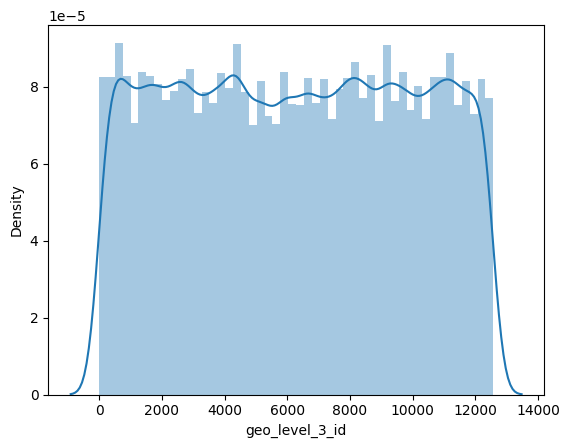

In [15]:
sns.distplot(df['geo_level_3_id'])

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1656\66781961.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['geo_level_2_id'])


<AxesSubplot: xlabel='geo_level_2_id', ylabel='Density'>

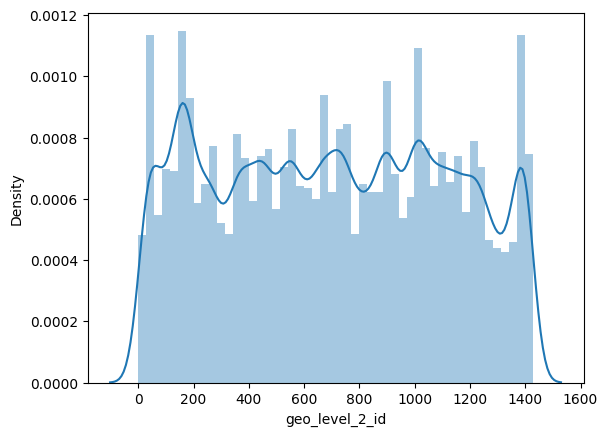

In [16]:
sns.distplot(df['geo_level_2_id'])

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1656\4024223850.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['geo_level_1_id'])


<AxesSubplot: xlabel='geo_level_1_id', ylabel='Density'>

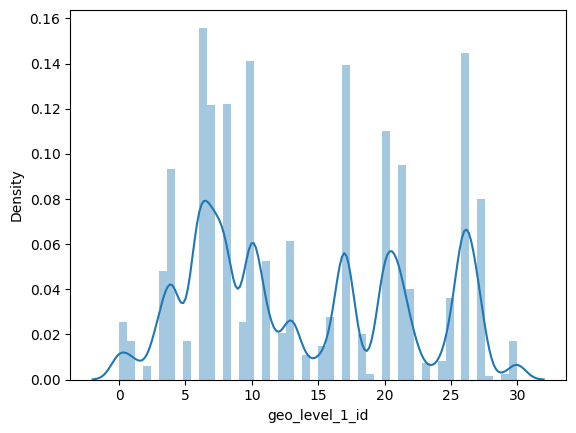

In [17]:
sns.distplot(df['geo_level_1_id'])

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


df[['geo_level_1_id','geo_level_2_id','geo_level_3_id']]=scaler.fit_transform(df[['geo_level_1_id','geo_level_2_id','geo_level_3_id']])

In [19]:
df['geo_level_1_id'].value_counts()

-0.983414    24381
 1.506130    22615
-0.485505    22079
 0.385835    21813
-0.734459    19080
-0.858937    18994
 0.759267    17216
 0.883744    14889
-1.232368    14568
 1.630607    12532
-0.112073     9608
-0.361028     8220
-1.356845     7540
 1.008221     6252
 1.381653     5624
 0.261358     4332
-1.730277     4011
-0.609982     3958
-0.236551     3194
 0.510312     3189
-1.605800     2701
-1.107891     2690
 2.004039     2686
 0.136881     2320
 0.012404     1714
 1.257175     1310
 1.132698     1121
-1.481322      931
 1.879561      396
 0.634790      372
 1.755084      265
Name: geo_level_1_id, dtype: int64

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1656\4024223850.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['geo_level_1_id'])


<AxesSubplot: xlabel='geo_level_1_id', ylabel='Density'>

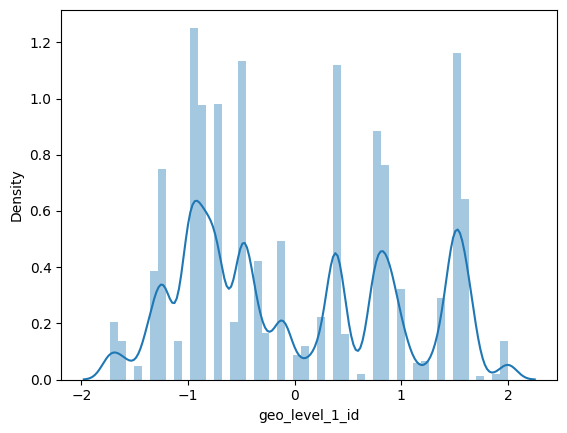

In [20]:
sns.distplot(df['geo_level_1_id'])

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1656\66781961.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['geo_level_2_id'])


<AxesSubplot: xlabel='geo_level_2_id', ylabel='Density'>

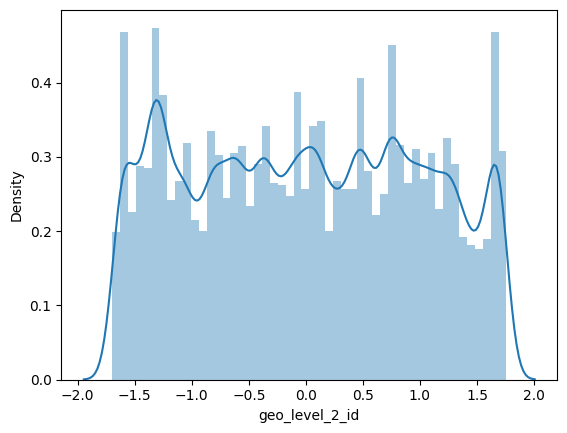

In [21]:
sns.distplot(df['geo_level_2_id'])

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1656\2541843919.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['geo_level_3_id'])


<AxesSubplot: xlabel='geo_level_3_id', ylabel='Density'>

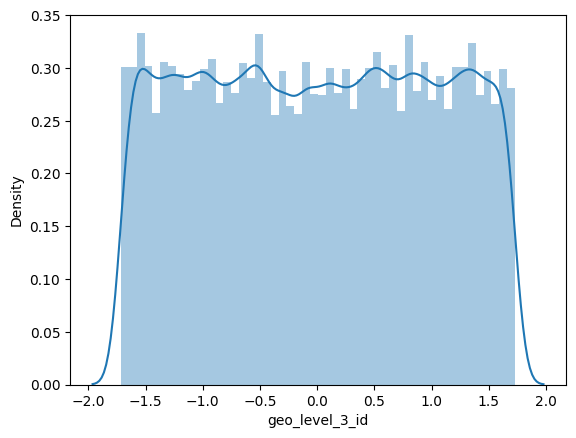

In [22]:
sns.distplot(df['geo_level_3_id'])

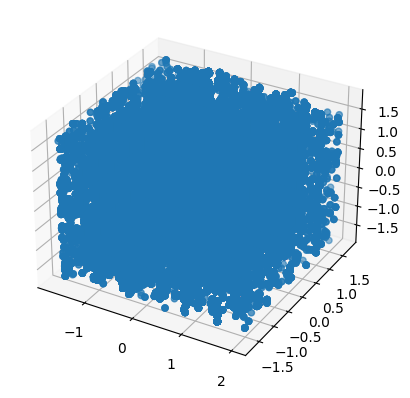

In [23]:
ax = plt.axes(projection ='3d')

ax.scatter(df['geo_level_1_id'],df['geo_level_2_id'],df['geo_level_3_id'])

plt.show()

In [33]:
X = df.iloc[:, [0,1,2]].values
X

array([[-0.98341369, -0.51870494],
       [-0.73445934,  0.48199788],
       [ 0.88374396, -0.81915808],
       ...,
       [ 0.38583526, -1.57513697],
       [ 1.50612985, -1.60421308],
       [ 0.88374396, -1.67690335]])

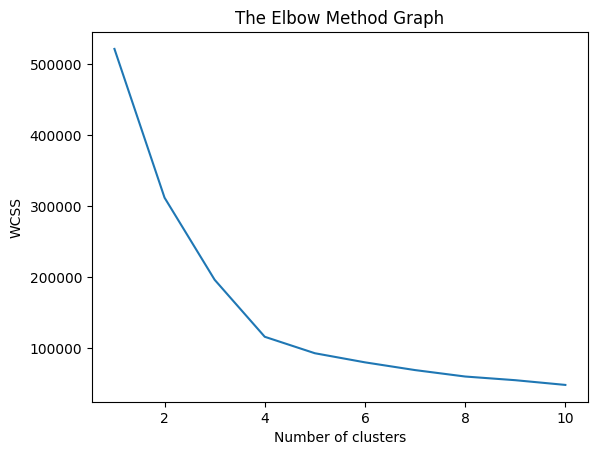

In [39]:
wcss=[]
#this loop will fit the k-means algorithm to our data and 
#second we will compute the within cluster sum of squares and #appended to our wcss list.
for i in range(1,11): 
     kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
#i above is between 1-10 numbers. init parameter is the random #initialization method  
#we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
#find the final clusters when the K-meands algorithm is running. we #enter the default value of 300
#the next parameter is n_init which is the number of times the #K_means algorithm will be run with
#different initial centroid.
     kmeans.fit(X)
#kmeans algorithm fits to the X dataset
     wcss.append(kmeans.inertia_)
#kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
#4.Plot the elbow graph
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [40]:
#5 According to the Elbow graph we deterrmine the clusters number as #5. Applying k-means algorithm to the X dataset.
kmeans = KMeans(n_clusters=4, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
# We are going to use the fit predict method that returns for each #observation which cluster it belongs to. The cluster to which #client belongs and it will return this cluster numbers into a #single vector that is  called y K-means
y_kmeans = kmeans.fit_predict(X)

In [42]:
df['localization']= y_kmeans

In [45]:
df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,localization
building_id,,,,,,,,,,,,,,,,,,,,,
802906,-0.983414,-0.518705,1.629055,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,3,3
28830,-0.734459,0.481998,-0.945017,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,2,0
94947,0.883744,-0.819158,0.744612,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,3,1
590882,1.008221,-0.685893,1.216589,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,2,1
201944,-0.361028,-1.381296,-1.308119,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,3,3


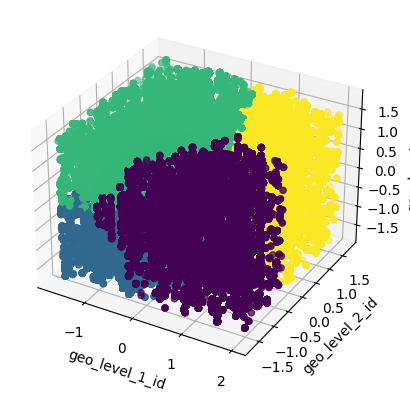

In [46]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']])

# Create the 3D scatter plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='black', marker='x')
ax.scatter(df['geo_level_1_id'], df['geo_level_2_id'], df['geo_level_3_id'], c=kmeans.labels_, cmap='viridis')
ax.set_xlabel('geo_level_1_id')
ax.set_ylabel('geo_level_2_id')
ax.set_zlabel('geo_level_3_id')
plt.show()


In [50]:
num_features=df.select_dtypes(np.number)

num_features

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,localization
building_id,,,,,,,,,,,,,,,,,,,,,
802906,-0.983414,-0.518705,1.629055,2,30,6,5,1,1,0,...,0,0,0,0,0,0,0,0,3,3
28830,-0.734459,0.481998,-0.945017,2,10,8,7,0,1,0,...,0,0,0,0,0,0,0,0,2,0
94947,0.883744,-0.819158,0.744612,2,10,5,5,0,1,0,...,0,0,0,0,0,0,0,0,3,1
590882,1.008221,-0.685893,1.216589,2,10,6,5,0,1,0,...,0,0,0,0,0,0,0,0,2,1
201944,-0.361028,-1.381296,-1.308119,3,30,8,9,1,0,0,...,0,0,0,0,0,0,0,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1.381653,1.536007,-1.271644,1,55,6,3,0,1,0,...,0,0,0,0,0,0,0,0,2,2
669485,0.385835,0.033741,-1.151250,2,0,6,5,0,1,0,...,0,0,0,0,0,0,0,0,3,2
602512,0.385835,-1.575137,0.522472,3,55,6,7,0,1,0,...,0,0,0,0,0,0,0,0,3,1


In [51]:
mutual_info = mutual_info_classif(num_features, df_label)
mutual_info

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1.32209180e-01, 2.35865034e-01, 2.95101908e-01, 2.97263400e-02,
       3.31355218e-02, 1.51228856e-02, 2.64470142e-02, 4.74267485e-03,
       6.74730418e-02, 2.64008489e-03, 1.81511590e-03, 2.66309257e-03,
       3.33696125e-02, 3.69582283e-03, 4.65762913e-03, 1.30854903e-02,
       1.71927249e-02, 2.01420728e-03, 2.39447932e-02, 3.05407059e-03,
       3.11535961e-03, 3.32598859e-03, 4.20761141e-03, 5.59915978e-04,
       6.64757101e-04, 0.00000000e+00, 8.42051780e-04, 1.07065136e-04,
       5.15705165e-04, 7.76870079e-04, 9.39442326e-01, 1.53239084e-02])

In [52]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = num_features.columns
mutual_info.sort_values(ascending=False) #Looking at the most important features

damage_grade                              0.939442
geo_level_3_id                            0.295102
geo_level_2_id                            0.235865
geo_level_1_id                            0.132209
has_superstructure_mud_mortar_stone       0.067473
has_superstructure_cement_mortar_brick    0.033370
age                                       0.033136
count_floors_pre_eq                       0.029726
height_percentage                         0.026447
count_families                            0.023945
has_superstructure_rc_engineered          0.017193
localization                              0.015324
area_percentage                           0.015123
has_superstructure_rc_non_engineered      0.013085
has_superstructure_adobe_mud              0.004743
has_superstructure_bamboo                 0.004658
has_secondary_use_rental                  0.004208
has_superstructure_timber                 0.003696
has_secondary_use_hotel                   0.003326
has_secondary_use_agriculture  

In [54]:
df_features = df.drop(['damage_grade'],axis=1)
df_target = df['damage_grade']

In [56]:
num_cols = df_features.select_dtypes(np.number)

In [57]:
pca = PCA(n_components=5)
pca.fit(num_cols)

PCA(n_components=5)

In [59]:
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [63]:
pipe.fit(num_cols,df_target)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [66]:
preds=pipe.predict(num_cols)
f1_score(df_target, preds, average='micro')

0.9688489299734077

In [71]:
col=num_cols.columns

<b>Test set</b>

######################################################################################

In [68]:
test_values= pd.read_csv('test_values.csv',index_col='building_id')

In [73]:
X = test_values.iloc[:, [0,1,2]].values
X

array([[   17,   596, 11307],
       [    6,   141, 11987],
       [   22,    19, 10044],
       ...,
       [   22,  1136,  7712],
       [    6,  1041,   912],
       [   26,    36,  6436]], dtype=int64)

In [75]:
#5 According to the Elbow graph we deterrmine the clusters number as #5. Applying k-means algorithm to the X dataset.
kmeans = KMeans(n_clusters=4, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
# We are going to use the fit predict method that returns for each #observation which cluster it belongs to. The cluster to which #client belongs and it will return this cluster numbers into a #single vector that is  called y K-means
y_kmeans = kmeans.fit_predict(X)

test_values['localization']= y_kmeans

In [78]:
num_features=test_values.select_dtypes(np.number)



In [83]:
predictions = pipe.predict(num_features)

print(predictions)

[2 2 2 ... 2 2 2]


In [84]:
np.unique(predictions,return_counts=True)

(array([1, 2, 3], dtype=int64), array([ 3866, 71123, 11879], dtype=int64))